## #1 Get DAS Variables in time frame of interest

In [1]:
import pandas as pd
# get date of first consult
df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC))

len(new_pat)

1251

In [23]:
import pandas as pd

# get disease activity scores
df_das44 = pd.read_csv(r'../data/1_raw/Clustering_Gewrichtspop_with_BSE.csv', sep='|')
len(df_das44['PATNR'].unique())

# get actual patient ids - for linking data
df_keys = pd.read_csv(r'../data/1_raw/Pseudonymized_Keys.csv', sep=';')
d_translation = dict(zip(df_keys.member_entity_Pseudonym_value, df_keys.member_entity_Patient_value))
df_das44['patnr'] = df_das44['subject_Patient_value'].apply(lambda x: d_translation[x])

# get date of first consult
df_pat = pd.read_csv(r'../filters/RA_patients_083.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))
df_das44['PEC'] = df_das44['patnr'].apply(lambda x: new_pat[x])

In [ ]:
import pandas as pd
new_df = pd.DataFrame()
cnt = 0

for pat in df_das44['patnr'].unique():
    sub_df = df_das44[df_das44['patnr']==pat].copy() # select pat
    
    try : 
        min_date = new_pat[pat] # get date of first consult
        min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
        max_date = min_date + pd.Timedelta(365, unit='d') # three months from first consult
        min_date = min_date - pd.DateOffset(days=1) # maybe a day earlier
        sub_df['item_answer_lastUpdateDate'] = pd.to_datetime(sub_df['item_answer_lastUpdateDate'], format='%Y-%m-%d', errors='ignore')
        #print(min_date, max_date, sub_df.head())
        sub_df = sub_df[sub_df['item_answer_lastUpdateDate'].between(min_date, max_date, inclusive=False)]
        #print(len(sub_df))
        new_df = new_df.append(sub_df, ignore_index=True)
        #print('%s in dataframe' % pat)
    except KeyError:
        #print('%s not in dataframe' % pat)
        continue
    cnt += 1
    #if cnt > 5:
    #    break

#new_df.to_csv(r'../data/2_preprocessing/DF_DAS44_firstCon.csv', sep='|', index=True)
new_df.head()

## #2 Calculate DAS-28 (3 variables) & DAS-44 (3 variables)
- Retrieve the Sedimentation rate (BSE)
- Combine sedimentation rate with mannequin variables
- export concatenated dataset to csv

In [ ]:
import pandas as pd

# Import Mannequin data
new_df = pd.read_csv(r'../data/1_raw/Clustering_Gewrichtspop.csv', sep=';', header=None)
new_df.columns = ['ID','PATNR','DATUM','DATUM_A', 'STELLING', 'ANTWOORD', 'XANTWOORD', 'YANTWOORD', 'CATEGORIE', 'OBJID']
new_df.head()

# Import Sedimentation rate (to calculate DAS28 score)
bse_df = pd.read_csv(r'../data/1_raw/Clustering_LAB_values_NewCutoff.csv', sep='|', index_col=0)
bse_df =bse_df[bse_df['test_naam_omschrijving']=='BSE']

df_pat = pd.read_csv(r'../filters/RA_patients_083.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))

bse_df= bse_df[bse_df['patient_id'].isin(new_pat.keys())]

# Add Sedimentation rate to Mannequin data
bse_df = pd.concat([pd.DataFrame([[i, bse_df['patient_id'].iloc[i], bse_df['Monster_Afname_Datumtijd'].iloc[i], bse_df['Monster_Afname_Datumtijd'].iloc[i], 'BSE', bse_df['uitslag_value'].iloc[i], bse_df['uitslag_value'].iloc[i], bse_df['uitslag_unit'].iloc[i], bse_df['Onderzoek'].iloc[i], bse_df['Aanvraagnummer'].iloc[i] ]], columns=['ID', 'PATNR', 'DATUM', 'DATUM_A', 'STELLING', 'ANTWOORD', 'XANTWOORD', 'YANTWOORD', 'CATEGORIE', 'OBJID']) for i in range(len(bse_df))],
          ignore_index=True)
new_df = pd.concat([new_df, bse_df])
new_df = new_df.reset_index(drop=True)
new_df.to_csv(r'../data/1_raw/Clustering_Gewrichtspop_with_BSE.csv', sep='|', index=False)

### #2.1 Import concatenated dataset once created

In [31]:
import pandas as pd

# Import Mannequin data with Sedimentation rate (BSE)
new_df = pd.read_csv(r'../data/1_raw/Clustering_Gewrichtspop_with_BSE.csv', sep='|')
new_df = new_df.sort_values(by=['PATNR', 'DATUM'])

# Get patient_ids
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))

### #2.2 Compute DAS
- sum the swollen and tender joint count according to the 44 and 28 criteria
- retrieve the ESR (in same time-frame)

In [41]:
import pandas as pd
import numpy as np
import re

def compute_DAS(df, patnr, first_date=None, verbose=False):
    """ 
    Subset on patnr and date (snapshot) and determine the number of 
    swollen- and tender joints. 
    
    We apply a fuzzy matching. The ESR is regularly out of sync with 
    the mannequin joint information, hence we apply a time window 
    (2 weeks before the visit and max of 2 days after the visit).
    
    We transform the dates into days according to the first date 
    provided by the user.
    
    We only calculate the DAS28(3) if we have joint information
    and the ESR variable available. We perform simple checks
    to ensure we have the joint information necessary. 
    They ensure us that we are not missing any information:
        - no_pain = indicates that there are no tender joints
        - no_swollen = indicates that there are no swollen joints
            
    If both of these variables score positive then we can safely
    compute DAS28(3) with only the ESR. However, we cease the DAS computation
    if we don't find any joint information while these variables 
    indicate the opposite, or when these variables aren't defined at all 
    (because of missing information).
    
    Input:
        - df = pandas Dataframe with mannequin data as well as ESR 
        - patnr = patient id
        - first date = users may supply the first consult date
            - this function takes the first date in the dataframe (df) by default
        - verbose = print out all information related to DAS computation
            - Indicate whenever the ESR is imputed (observation carried forward or backward)
            - Indicate whenever a DAS is extracted directly from the table (i.e. not computed)
            - Indicate whenever the DAS could not be computed because joint information is missing
            - Indicate whenever the DAS could not be computed because ESR is missing
            
    ToDo: get BSE from LAB
    """
    l_DAS28_tjc = ['Pijn_pols L', 'Pijn_pols R', 'Pijn_pip 2 links hand', 'Pijn_pip 2 rechts hand', 'Pijn_pip 3 links hand', 'Pijn_pip 3 rechts hand',
 'Pijn_pip 4 links hand', 'Pijn_pip 4 rechts hand', 'Pijn_pip 5 links hand', 'Pijn_pip 5 rechts hand', 
 'Pijn_mcp 1 links', 'Pijn_mcp 1 rechts', 'Pijn_mcp 2 links', 'Pijn_mcp 2 rechts', 'Pijn_mcp 3 links', 'Pijn_mcp 3 rechts',
 'Pijn_mcp 4 links', 'Pijn_mcp 4 rechts', 'Pijn_mcp 5 links', 'Pijn_mcp 5 rechts', 'Pijn_IP links', 'Pijn_IP rechts', 'Pijn_schouder L', 'Pijn_schouder R', 'Pijn_Elleboog L','Pijn_elleboog R',
 'Pijn_knie links', 'Pijn_knie rechts']
           
    l_DAS28_sjc = [ 'Zwelling_pols L', 'Zwelling_pols R', 'Zwelling_pip 2 links hand',  'Zwelling_pip 2 rechts hand',
     'Zwelling_pip 3 links hand',  'Zwelling_pip 3 rechts hand', 'Zwelling_pip 4 links hand', 'Zwelling_pip 4 rechts hand',  'Zwelling_pip 5 links hand',
     'Zwelling_pip 5 rechts hand',  'Zwelling_mcp 1 links', 'Zwelling_mcp 1 rechts', 'Zwelling_mcp 2 links', 'Zwelling_mcp 2 rechts', 'Zwelling_mcp 3 links', 'Zwelling_mcp 3 rechts',
     'Zwelling_mcp 4 links', 'Zwelling_mcp 4 rechts', 'Zwelling_mcp 5 links', 'Zwelling_mcp 5 rechts', 
     'Zwelling_knie links', 'Zwelling_knie rechts', 'Zwelling_schouder L', 'Zwelling_schouder R', 'Zwelling_Elleboog L',
      'Zwelling_elleboog R', 'Zwelling_IP links', 'Zwelling_IP rechts'
                       ]
     
    l_DAS44_tjc = ['Pijn_pols L', 'Pijn_pols R', 'Pijn_pip 2 links hand', 'Pijn_pip 2 rechts hand', 'Pijn_pip 3 links hand', 'Pijn_pip 3 rechts hand',
 'Pijn_pip 4 links hand', 'Pijn_pip 4 rechts hand', 'Pijn_pip 5 links hand', 'Pijn_pip 5 rechts hand', 
 'Pijn_mcp 1 links', 'Pijn_mcp 1 rechts', 'Pijn_mcp 2 links', 'Pijn_mcp 2 rechts', 'Pijn_mcp 3 links', 'Pijn_mcp 3 rechts',
 'Pijn_mcp 4 links', 'Pijn_mcp 4 rechts', 'Pijn_mcp 5 links', 'Pijn_mcp 5 rechts', 'Pijn_IP links', 'Pijn_IP rechts', 'Pijn_schouder L', 'Pijn_schouder R', 'Pijn_Elleboog L','Pijn_elleboog R',
 'Pijn_knie links', 'Pijn_knie rechts',
            'Pijn_sternoclaviculair L', 'Pijn_sternoclaviculair R', 'Pijn_acromioclaviaculair L',
'Pijn_acromioclaviaculair R', 'Pijn_pip 2 links voet', 'Pijn_pip 2 rechts voet',
'Pijn_pip 3 links voet', 'Pijn_pip 3 rechts voet',  'Pijn_pip 4 links voet', 
'Pijn_pip 4 rechts voet', 'Pijn_pip 5 links voet', 'Pijn_pip 5 rechts voet',
'Pijn_onderste spronggewricht links', 'Pijn_onderste spronggewricht rechts',
'Pijn_bovenste spronggewicht links', 'Pijn_bovenste spronggewricht rechts',
               ]
    l_DAS44_sjc = ['Zwelling_pols L', 'Zwelling_pols R', 'Zwelling_pip 2 links hand',  'Zwelling_pip 2 rechts hand',
     'Zwelling_pip 3 links hand',  'Zwelling_pip 3 rechts hand', 'Zwelling_pip 4 links hand', 'Zwelling_pip 4 rechts hand',  'Zwelling_pip 5 links hand',
     'Zwelling_pip 5 rechts hand',  'Zwelling_mcp 1 links', 'Zwelling_mcp 1 rechts', 'Zwelling_mcp 2 links', 'Zwelling_mcp 2 rechts', 'Zwelling_mcp 3 links', 'Zwelling_mcp 3 rechts',
     'Zwelling_mcp 4 links', 'Zwelling_mcp 4 rechts', 'Zwelling_mcp 5 links', 'Zwelling_mcp 5 rechts', 
     'Zwelling_knie links', 'Zwelling_knie rechts', 'Zwelling_schouder L', 'Zwelling_schouder R', 'Zwelling_Elleboog L',
      'Zwelling_elleboog R', 'Zwelling_IP links', 'Zwelling_IP rechts'
            'Zwelling_sternoclaviculair L', 'Zwelling_sternoclaviculair R', 'Zwelling_acromioclaviaculair L',
'Zwelling_acromioclaviaculair R', 'Zwelling_pip 2 links voet', 'Zwelling_pip 2 rechts voet',
'Zwelling_pip 3 links voet', 'Zwelling_pip 3 rechts voet',  'Zwelling_pip 4 links voet', 
'Zwelling_pip 4 rechts voet', 'Zwelling_pip 5 links voet', 'Zwelling_pip 5 rechts voet',
'Zwelling_onderste spronggewricht links', 'Zwelling_onderste spronggewricht rechts',
'Zwelling_bovenste spronggewicht links', 'Zwelling_bovenste spronggewricht rechts'
               ]   
    
    snapshots = list(df[((df['PATNR']==patnr)&(df['STELLING']!='BSE'))]['DATUM'].unique()) 
    # BSE is sometimes measured before Mannequin
    bse_df = df[((df['PATNR']==patnr)&(df['STELLING']=='BSE'))].copy()
    bse_df = bse_df.sort_values(by='DATUM')
    bse_df = bse_df.dropna(subset=['XANTWOORD'])
    
    # DAS28 is sometimes measured before Mannequin?
    das28_df = df[((df['PATNR']==patnr)&(df['STELLING']=='DAS 28'))].copy()
    das28_df = das28_df.sort_values(by='DATUM')
    das28_df = das28_df.dropna(subset=['XANTWOORD'])
    
    if first_date == None:
        first_date = pd.to_datetime(snapshots[0], format='%Y-%m-%d', errors='ignore')
    else :
        first_date = pd.to_datetime(first_date, format='%Y-%m-%d', errors='ignore')
    
    if verbose : print('Patnr %s' % (patnr))
        
    l_das = []
    d_das = {}
    d_missing = {}
    df_das = pd.DataFrame(columns=['patnr','date', 'days', 'DAS28(3)', 'SJC', 'TJC', 'ESR', 'SJC44', 'TJC44', 'DAS44'])
    
    for snap in snapshots:
        days = (pd.to_datetime(snap, format='%Y-%m-%d', errors='ignore').tz_localize('UTC') - first_date).days 
        snapshot_df = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING'].isin(['Zwelling', 'Pijn'])))].copy()
        snapshot_df = snapshot_df.assign(XANTWOORD=snapshot_df['STELLING'] + "_" + snapshot_df['XANTWOORD'])
        #print('Length of items %s at %s: %s' % (str(patnr), str(snap), str(len(snapshot_df))))
        if verbose : print('Date %s = %s days' % (str(snap), str(days)))
        c_tjc = 0
        c_sjc = 0
        c_tjc44 = 0
        c_sjc44 = 0
        esr = 0
        
        das = 0
        das44 = 0
        index = len(df_das)
        
        # Check for exceptions whereby patient doesn't have painful or swollen joints
        #  Note: Try and except is faster than checking with if (especially since we are dealing with exceptional cases)
        try : 
            no_pain = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='Totaal pijnlijke gewrichten'))]['XANTWOORD'].iloc[i]
            if no_pain == 0:
                no_pain = 'Y'
            else :
                no_pain = 'N'
        except:
            no_pain = 'N'
        try : 
            no_swollen = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='Totaal gezwollen gewrichten'))]['XANTWOORD'].iloc[i]
            if no_swollen == 0:
                no_swollen = 'Y'
            else :
                no_swollen = 'N'
        except:
            no_swollen = 'N'
            
        try : 
            no_pain = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='Geen pijnlijke gewrichten'))]['XANTWOORD'].iloc[i]
        except:
            no_pain = 'N'
        
        try :
            no_swollen = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='Geen gezwollen gewrichten'))]['XANTWOORD'].iloc[i]
        except:
            no_swollen = 'N'
            
        try : 
            no_pain = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='Pijnlijke gewrichten'))]['XANTWOORD'].iloc[i]
            if no_pain == 'geen.':
                no_pain = 'Y'
            else :
                no_pain = 'N'
        except:
            no_pain = 'N'
        
        try : 
            no_swollen = df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='Gezwollen gewrichten'))]['XANTWOORD'].iloc[i]
            if no_swollen == 'geen.':
                no_swollen = 'Y'
            else :
                no_swollen = 'N'
        except:
            no_swollen = 'N'
            
        
        # Sometimes you'll find that ESR is nan - in that case continue searching
        l1 = len(df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='BSE'))]['XANTWOORD'])
        for i in range(l1):
            if esr == 0 or esr == np.nan:
                esr = float(df[((df['PATNR']==patnr) & (df['DATUM'] == snap) & (df['STELLING']=='BSE'))]['XANTWOORD'].iloc[i])
            else :
                break
        
        def nearest_before(items, pivot):
            if len([i for i in items if i <= pivot]) > 0:
                return min([i for i in items if i <= pivot], key=lambda x: abs(x - pivot))
            else :
                return pivot + pd.DateOffset(days=999) # incredibly large number to prevent observation is carried forward
        def nearest_after(items, pivot):
            if len([i for i in items if i >= pivot]) > 0:
                return min([i for i in items if i >= pivot], key=lambda x: abs(x - pivot)) 
            else :
                return pivot + pd.DateOffset(days=999) # incredibly large number to prevent observation is carried backward

        
        # If you still don't find any ESR - look in range
        if esr == 0 or esr == np.nan:
            d1 = pd.to_datetime(bse_df['DATUM'], format='%Y-%m-%d', errors='ignore')
            d2 = pd.to_datetime(snap, format='%Y-%m-%d', errors='ignore')
            early = nearest_before(d1, d2) 
            late = nearest_after(d1, d2)

            if ((abs(late-d2).days) < (abs(d2-early).days)) and (abs(late-d2).days) < 3:
                esr = float(df[((df['PATNR']==patnr)&(df['STELLING']=='BSE')&(df['DATUM'].str.contains(str(late))))]['XANTWOORD'].iloc[0])
                if verbose : print("0 ->", esr, "Imputed from",  late, "which is", abs(late-d2).days, "days after date", d2)
            
            elif (abs(d2-early).days) < 14 and early != None: # less than two weeks
                #print(df[((df['PATNR']==patnr)&(df['STELLING']=='BSE')&(df['DATUM'].str.contains(early)))]['XANTWOORD'])
                esr = float(df[((df['PATNR']==patnr)&(df['STELLING']=='BSE')&(df['DATUM'].str.contains(str(early))))]['XANTWOORD'].iloc[0])
                if verbose : print("0 ->", esr, "Imputed from",  early, "which is", abs(d2-early).days, "days before date", d2)
        
        
            
        # Only calculate DAS if there is mannequin information
        # easy check by looking for joints. If there are no joints, look for 'Geen pijnlijke gewrichten'
        # and 'Geen gezwollen gewrichten'
        if esr != 0 and esr != np.nan:
            l_history= []
            l_history44 = []
            for key in snapshot_df['XANTWOORD']:
                if  key in l_DAS28_tjc and key not in l_history: 
                    c_tjc += 1
                    l_history.append(key)
                elif key in l_DAS28_sjc and key not in l_history: 
                    c_sjc += 1
                    l_history.append(key)
                
                if  key in l_DAS28_tjc and key not in l_history44: 
                    c_tjc44 += 1
                    l_history44.append(key)
                elif key in l_DAS44_sjc and key not in l_history44: 
                    c_sjc44 += 1
                    l_history44.append(key)

        if ((c_tjc + c_sjc) != 0 or (no_pain=='Y' and no_swollen=='Y')) and esr != 0:
            das = calculate_DAS28(c_tjc, c_sjc, esr)
            das44 = calculate_DAS44(c_tjc44, c_sjc44, esr)
            d_das[days] = das
            df_das.loc[index] = [patnr, snap, days, das, c_sjc, c_tjc, esr, c_sjc44, c_tjc44, das44]
        else :
            # DAS28
            if len(df[((df['PATNR']==patnr)&(df['STELLING'].isin(['DAS 28', 'DAS 28(3)']))& (df['DATUM'].str.contains(str(snap))))]['XANTWOORD']) > 0: # look for DAS
                if verbose : print('Cannot compute DAS28; will extract directly from table', snap)
                das = df[((df['PATNR']==patnr)&(df['STELLING'].isin(['DAS 28', 'DAS 28(3)']))& (df['DATUM'].str.contains(str(snap))))]['XANTWOORD'].iloc[0]
                if type(das) != float: # the raw value should be a string type
                    if 'VALUE1' in das:
                        das = re.search("VALUE1\=(\d+\,?(?:\d+)?)", das).group(1)
                    das = float(das.replace(",", ".")) # english notation
                    d_das[days] = das
                    df_das.loc[index] = [patnr, snap, days, das, c_sjc, c_tjc, esr, c_sjc44, c_tjc44, das44]
            else :
                if esr == 0 or esr == np.nan:
                    if verbose : print('Cannot compute DAS28: ESR is missing at', snap)
                else :    
                    if verbose : print('Cannot compute DAS28: joint information is missing at', snap)
                d_missing[days] = 0
                
            # DAS44    
            if len(df[((df['PATNR']==patnr)&(df['STELLING'].isin(['DAS 44', 'DAS 44(3)']))& (df['DATUM'].str.contains(str(snap))))]['XANTWOORD']) > 0: # look for DAS
                if verbose : print('Cannot compute DAS44; will extract directly from table', snap)
                das44 = df[((df['PATNR']==patnr)&(df['STELLING'].isin(['DAS 44', 'DAS 44(3)']))& (df['DATUM'].str.contains(str(snap))))]['XANTWOORD'].iloc[0]
                #print(das)
                if type(das44) != float: # the raw value should be a string type
                    if 'VALUE1' in das44:
                        das44 = re.search("VALUE1\=(\d+\,?(?:\d+)?)", das44).group(1)
                    das44 = float(das44.replace(",", ".")) # english notation
                    df_das.loc[index] = [patnr, snap, days, das, c_sjc, c_tjc, esr, c_sjc44, c_tjc44, das44]
                #l_das.append(das)
            else :
                if esr == 0 or esr == np.nan:
                    if verbose : print('Cannot compute DAS44: ESR is missing at', snap)
                else :    
                    if verbose : print('Cannot compute DAS44: joint information is missing at', snap)
                d_missing[days] = 0
                
                
            # DAS 44(3)
            #except IndexError:
            #    continue
            
        #if snap == '2016-01-20 00:00:00.000':
        #    print(str(patnr), str(snap), str(len(snapshot_df)), esr, c_tjc, c_sjc)
        
    return d_das, d_missing, df_das

def calculate_DAS28(tjc, sjc, esr):
    """
    Calculate DAS28 with 3 variables : TJC, SJC and ESR (BSE)
    """
    das28 = (0.56 * np.sqrt(tjc) + 0.28 * np.sqrt(sjc) + 0.70 * np.log(esr)) * 1.08 + 0.16
    return das28

def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """
    
    das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 #0.224
    return das44


#d_bin = {}
#bin_size =3
l_pat = []
for pat in list(new_df['PATNR'].unique())[:250]:
    l_pat.append(pat)

### #2.3 Export DAS information to csv

In [ ]:
import numpy as np

def collect_all_das(df, bin_size=20, first_dates=None, verbose=False):
    """
    Collect all DAS values by computing the DAS or by extracting the DAS from the table.
    
    All of the DAS values are then exported to a standardized table
    """
    d_bin = {}
    df_ultimate_das = pd.DataFrame(columns=['patnr','date', 'days', 'DAS28(3)', 'SJC', 'TJC', 'ESR']) 
    
    for pat in list(df['PATNR'].unique()):
        d_das, d_missing, df_das = compute_DAS(df, patnr=pat, first_date=first_dates[pat], verbose=verbose)
        df_ultimate_das = pd.concat([df_ultimate_das, df_das])
        
        print('patnr:', pat) # , d_das, first_dates[pat]
        mylist = np.array(list(d_das.keys()))

        bins = np.arange(0,450,bin_size)
        for i in range(1,int(450/bin_size)):
            #if i == 14:
            #    print([d_das[i] for i in mylist[np.digitize(mylist,bins)==i]], pat, mylist[i])
            #d_bin[i] = [d_das[i] for i in mylist[np.digitize(mylist,bins)==i]]
            if i in d_bin:
                #print(mylist[np.digitize(mylist,bins)==i])
                d_bin[i].extend([d_das[i] for i in mylist[np.digitize(mylist,bins)==i]])
            else :
                d_bin[i] = [d_das[i] for i in mylist[np.digitize(mylist,bins)==i]]
        
    return d_bin, d_das, df_ultimate_das


BIN_SIZE = 20  
d_bin, d_das, df_das = collect_all_das(new_df[new_df['PATNR']==311022], BIN_SIZE, first_dates=new_pat, verbose=False)

# Export DAS information to csv
df_das.to_csv('../data/8_final/DAS_patients.csv', index=False)

## #3 Get Medicator entries in time frame of interest
Get medication within 1 year from baseline and export to csv file

In [ ]:
import pandas as pd

df_pat = pd.read_csv(r'../filters/RA_patients_083.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))


new_df = pd.DataFrame()
cnt = 0

for pat in df_med['PATNR'].unique():
    sub_df = df_med[df_med['PATNR']==pat].copy() # select pat
    
    try : 
        min_date = new_pat[pat] # get date of first consult
        min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
        max_date = min_date + pd.Timedelta(356, unit='d') # three months from first consult
        min_date = min_date - pd.DateOffset(days=1) # maybe a day earlier
        sub_df['periodOfUse_valuePeriod_start_date'] = pd.to_datetime(sub_df['periodOfUse_valuePeriod_start_date'], format='%Y-%m-%d', errors='ignore')
        #print(min_date, max_date, sub_df.head())
        sub_df = sub_df[sub_df['periodOfUse_valuePeriod_start_date'].between(min_date, max_date, inclusive=False)]
        #print(len(sub_df))
        new_df = new_df.append(sub_df, ignore_index=True)
        #print('%s in dataframe' % pat)
    except KeyError:
        #print('%s not in dataframe' % pat)
        continue
    cnt += 1
    #if cnt > 5:
    #    break

new_df.to_csv(r'../data/7_clustering/Clustering_Medicator_NewCutoff_2.csv', sep='|', index=True)
new_df.head()

### #3.1 Import selection of Medicator data

In [ ]:
import pandas as pd

df_med = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/7_medication/Clustering_Medicator_NewCutoff_2.csv', sep=';', header=None)
df_med.columns = ['PATNR', 'periodOfUse_valuePeriod_start_date', 'periodOfUse_valuePeriod_end_date', 'usageDuration_valueDuration_value', 'dosageInstruction_text', 'dosageInstruction_additionalInstruction_text', 'dosageInstruction_timing_repeat_frequency', 'dosageInstruction_timing_repeat_period', 'dosageInstruction_route_display', 'dosageInstruction_doseQuantity_value', 'dosageInstruction_doseQuantity_unit_display_original', 'code_text', 'ATC_code', 'ATC_display', 'ATC_display_nl']

# get actual patient ids - for linking data
df_keys = pd.read_csv(r'../data/1_raw/Pseudonymized_Keys.csv', sep=';')
d_translation = dict(zip(df_keys.member_entity_Pseudonym_value, df_keys.member_entity_Patient_value))
df_med['PATNR'] = df_med['PATNR'].apply(lambda x: d_translation[x])

df_med.head()

### #3.2 Process Medicator data

In [ ]:
import re
import numpy as np

def extract_dose(row):
    """ 
    Extract the dose embedded in the code_text column. 
    We multiply by quantity in case a patient recieves multiple
    'portions' in a day
    
    Input:
        row = single row from medicator
    Output:
        dose = dose retrieved from the description
        unit = quantity unit 
    """
    
    dose = np.nan
    unit = np.nan
    one_off = False
    ambiguous = False
    quantity = str(row['quantity']).replace(',', '.')
    
    # eenamlig - single use op meerdere data
    # Check if only a single use 
    if 'eenmalig' in row['instruction']:
        one_off = True
        
    #if row['instruction'].contains(['daarna', '; na', 'eenamlig']):
    #    ambiguous = True
        
    code_instruction = row['instruction']
    l_cand  = re.findall('(\(?)(\d+\,?\.?\d+)(MG|mg|milligram|ml)', code_instruction)
    if len(l_cand) == 0:
        #print('not found')
        code_text = row['codeText']
        l_cand = re.findall('(\(?)(\d+\,?\d+)(MG)', code_text)
    #    code_text = row['codeText']
    #    l_cand = re.findall('(\(?)(\d+\,?\d+)(MG)', code_text)
    
    
    for cand in l_cand:
        if cand[0] != '(':
            dose, unit = float(cand[1].replace(',', '.')), cand[2]
    
    # Calculate total concentration if you have multiple pills
    if row['unit'] == 'STUK':
        if quantity != '0' and quantity != np.nan: 
            dose *= float(quantity)
        
    # Just use values directly from columns  
    # (Except when route==SUBCUTAAN) because these values aren't
    # always properly registered
    elif row['route']!='SUBCUTAAN' and row['route']!='PARENTERAAL' and \
    row['drugName']!='HYDROXYCHLOROQUINE' and one_off == False and row['quantity']!='0':
        dose = row['quantity']
        unit = row['unit']
    d_trans = {'MG' : 'MILLIGRAM', 'ml' : 'MILLILITER', 'mg' : 'MILLIGRAM', 'MILLIGRAM' : 'MILLIGRAM'}
    if unit in d_trans:
        unit = d_trans[unit]#'MILLIGRAM'
    return dose, unit, one_off

def format_medication_table(df):
    cols = ['PATNR', 'periodOfUse_valuePeriod_start_date', 'periodOfUse_valuePeriod_end_date', 'usageDuration_valueDuration_value', 'dosageInstruction_text', 'dosageInstruction_timing_repeat_frequency', 'dosageInstruction_timing_repeat_period', 'dosageInstruction_route_display', 'dosageInstruction_doseQuantity_value', 'dosageInstruction_doseQuantity_unit_display_original', 'code_text', 'ATC_display_nl']
    new_cols = ['patnr', 'startDate', 'endDate', 'duration', 'instruction', 'frequencyUnit', 'repeatPeriod',  'route', 'quantity', 'unit', 'codeText', 'drugName']

    df = df[cols].copy()
    df.columns = new_cols
    
    df['extractDose'], df['extractUnit'], df['oneOff'] = zip(*df.apply(lambda x: extract_dose(x), axis=1))
    return df 
df_med = format_medication_table(df_med)
df_med.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/7_medication/Clustering_Medicator_formatted.csv', sep=';', index=False)

## #4 Elucidate treatment efficacy 

In [53]:
# Load processed DAS table
df_das = pd.read_csv('../data/8_final/DAS_patients.csv')

# Load processed Medicator
df_med = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/7_medication/Clustering_Medicator_formatted.csv', sep=';')

### #4.1 Overlap DAS with Treatment information

In [ ]:
import pandas as pd
import numpy as np

def create_treatment_composite(df_med, df_das, first_dates):
    """
    Create a table for downstream analysis of treatment response
    
    Input:
        - df_med = processed table with Medication information
        - df_das = processed table with DAS information
        - first_dates = list with first dates
    Output:
        - df_treat = composite table with DAS28(3) combined with current treatment information
    """
    
    df_treat = pd.DataFrame(columns=['patnr', 'treatID', 'Drug', 'Dosage', 'Unit', 'Instruction', 'StartDateTreatment', 'EndDateTreatment', 'daysTreatment', 'DAS28(3)', 'dateDAS', 'daysDAS', 'SJC', 'TJC', 'ESR', 'extractDate']) # columns=['patnr', 'DAS28(3)', 'CurTreatment', 'Dosage', 'date', 'days', 'daysCurTreatment'
    tol = 1
    
    
    
    for patnr in df_das['patnr'].unique():
        print(patnr)
        first_date = pd.to_datetime(first_dates[patnr], format='%Y-%m-%d', errors='ignore')
        sub_df = df_med[df_med['patnr']==patnr].copy() # select pat
        
        sub_das = df_das[df_das['patnr']==patnr].copy()
        #print(pd.DateOffset(years=1))
        #print(pd.DateOffset(days=sub_das['days'].min()))
        #print(pd.to_timedelta(sub_das['days'].min(), unit='d'))
        #first_date = pd.to_datetime(sub_das['date'].min(), format='%Y-%m-%d', errors='ignore') - pd.to_timedelta(sub_das['days'].min(), unit='d')
        #pd.DateOffset(days=sub_das['days'].min())
        
        l_das = list(sub_das['days'].values)
        l_med = []
        
        for ix, drug in enumerate(sub_df['drugName'].values):
            startDate = sub_df['startDate'].iloc[ix]
            endDate = sub_df['endDate'].iloc[ix]
            #print(startDate, endDate)
            
            cor_das = sub_das[(pd.to_datetime(startDate, format='%Y-%m-%d', errors='ignore') - pd.DateOffset(days=tol) <= pd.to_datetime(sub_das.date, format='%Y-%m-%d', errors='ignore')) & (pd.to_datetime(endDate, format='%Y-%m-%d', errors='ignore') + pd.DateOffset(days=tol) >= pd.to_datetime(sub_das.date, format='%Y-%m-%d', errors='ignore'))]#.iloc[0]
            delta_days = pd.to_datetime(startDate, format='%Y-%m-%d', errors='ignore') - first_date
            delta_days = delta_days.days
            for index, match in cor_das.iterrows():
                df_treat.loc[len(df_treat)] = [patnr, '%s_%s' % (patnr, ix), sub_df['drugName'].iloc[ix], sub_df['extractDose'].iloc[ix], sub_df['extractUnit'].iloc[ix], sub_df['instruction'].iloc[ix], sub_df['startDate'].iloc[ix], sub_df['endDate'].iloc[ix], delta_days, match['DAS28(3)'], match['date'], match['days'], match['SJC'], match['TJC'], match['ESR'], sub_df['startDate'].iloc[ix]]
                if match['days'] in l_das: # bookkeeping DAS
                    l_das.remove(match['days'])
            if len(cor_das) == 0: # bookkeeping Medication
                l_med.append(ix)

        for days in l_das:
            match = sub_das[sub_das['days']==days].iloc[0]
            df_treat.loc[len(df_treat)] = [patnr, np.nan, 'NO MEDICATION', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, match['DAS28(3)'], match['date'], match['days'], match['SJC'], match['TJC'], match['ESR'], match['date']]
        for ix in l_med:
            df_treat.loc[len(df_treat)] = [patnr, '%s_%s' % (patnr, ix), sub_df['drugName'].iloc[ix], sub_df['extractDose'].iloc[ix], sub_df['extractUnit'].iloc[ix], sub_df['instruction'].iloc[ix], sub_df['startDate'].iloc[ix], sub_df['endDate'].iloc[ix], delta_days, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, sub_df['startDate'].iloc[ix]]
    
    df_treat = df_treat.sort_values(by='extractDate').reset_index(drop=True)
    return df_treat 

# Get first dates
df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC))

# Create composite tables
df_treat = create_treatment_composite(df_med, df_das, first_dates=new_pat)
df_treat.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/TreatmentResponseTable.csv', sep=';')

### #4.2 Import composite treatment response table

In [ ]:
import pandas as pd

df_treat = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/TreatmentResponseTable.csv', sep=';')
df_treat

### #4.3 Visualize medical trajectory of patients

In [ ]:
import pandas as pd

df_das = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/DAS_patients.csv')
df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/all_data_Mofa_clustering.csv')
df_treat = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/TreatmentResponseTable.csv', sep=';')

df_cluster.head()

### #4.4 Plot days till treatment

Text(0, 0.5, 'nr of entries')

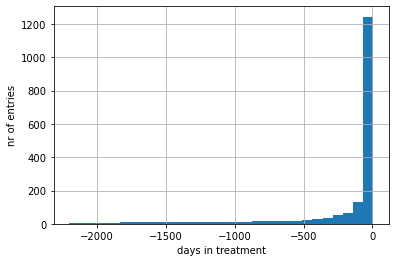

In [89]:
ax = df_das[df_das['days_in_treat']<7]['days_in_treat'].hist(bins=30)
ax.set_xlabel('days in treatment')
ax.set_ylabel('nr of entries')

## #5 Create Baseline table & Visualize response

In [ ]:
import pandas as pd
import numpy as np

# Load DAS
df_das = pd.read_csv('../data/8_final/DAS_patients.csv')

# Preload function
def getFirstPEC(pat, clean_dict):
    if pat in clean_dict.keys():
        return clean_dict[int(pat)]
    else :
        return np.nan

df_pat = pd.read_csv('../filters/RA_patients_083_new.csv',sep=',')
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC)) # 

# Add first consult date
df_das['PEC'] = df_das['patnr'].apply(lambda x: getFirstPEC(x, new_pat))
df_das = df_das[~df_das['PEC'].isna()]

df_das['new_days'] = (pd.DatetimeIndex(pd.to_datetime(df_das['date'], format='%Y-%m-%d', errors='ignore')).tz_localize('UTC') - pd.DatetimeIndex(pd.to_datetime(df_das['PEC'], format='%Y-%m-%d', errors='ignore'))).days
df_das.head()

### #5.1 retrieve DAS before first treatment

In [3]:

# Load Medicator
df_treat = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/TreatmentResponseTable.csv', sep=';')

# Load cluster information
df_cluster = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/all_data_Mofa_clustering2.csv')

# Look from August 29, 2011 onwards
df_treat = df_treat[(pd.DatetimeIndex(pd.to_datetime(df_treat['StartDateTreatment'], format='%Y-%m-%d', errors='ignore')))>pd.to_datetime('20110829', format='%Y-%m-%d', errors='ignore')]

# Assess first date of treatment
d_firstTreatDate =df_treat.groupby(['patnr'])['StartDateTreatment'].agg('min').to_dict()

# Preload function to acquire date of first consult from dictionary
def getFirstTREATPEC(pat, d_first):
    if pat in d_first.keys():
        return d_first[int(pat)]
    else :
        return np.nan

# Add first consult date
df_das['TREATPEC'] = df_das['patnr'].apply(lambda x: getFirstTREATPEC(x, d_firstTreatDate))

# calculate days till treatment df_das['TREATPEC']
df_das['days_in_treat'] = pd.to_datetime(df_das['date'], format='%Y-%m-%d', errors='ignore') - pd.to_datetime(df_das['TREATPEC'], format='%Y-%m-%d', errors='ignore')
df_das['days_in_treat'] = df_das['days_in_treat'].dt.days

### #5.2 Create Table with baseline characteristics

In [4]:
def IQR(data):
    # First quartile (Q1)
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')

    # Third quartile (Q3)
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
   
    # Interquaritle range (IQR)
    iqr = Q3 - Q1
    return iqr

def create_baselineTable(df_cluster, df_das, df_treat, col_cluster):
    """
    Create a baseline table
    
    Input:
        df_cluster = table with lab/mannequin baseline variables and final clusters 
        df_das = table with DAS scores
        df_treat = table with treatment
        col_cluster = the column in df_cluster that features the cluster ids
        # treatment switch?
    Output:
        df_baseline = 
        
    ToDo:
        N = number of DAS != number of medication
    """
    l_miss_tot = 0
    l_miss_final = 0
    df_baseline = pd.DataFrame(columns=['cluster', 'N', 'Sex [n(%)]', 'RF [n(%)]', 'aCCP [n(%)]', 'DAS44 (median+-IQR)', 'SJC (median+-IQR)', 'TJC (median+-IQR)', 'ESR (median+-IQR, mm/hr)', 'Age (mean+-SD, yr)', 'DAS28 (median+-IQR)', 'final_DAS28 (median+-IQR)', 'prevalence_TreatSwitch [n(%)]', 'MTX [n(%)]', 'Follow up (median+-IQR, days)', 'ENA-missingness [n(%)]', 'Small joints (median+-IQR)', 'Big joints (median+-IQR)', 'Symmetrical joints (median+-IQR)'])
    d_response = {} # patnr; [begin, end]
    d_firstSwitch = {}
    d_totalFollowUp = {}
    for cluster in df_cluster[col_cluster].unique():
        sub_df = df_cluster[df_cluster[col_cluster]==cluster].copy()
        
        # Features to extract for each cluster
        l_das = []
        l_sjc = []
        l_tjc = []
        l_rf = []
        l_accp = []
        l_esr = []
        l_age = []
        l_sex = []
        l_das28 = []
        l_das28_final = [] 
        l_sjc_final = [] 
        l_tjc_final = [] 
        l_response = [] # ' Unknown', 'Positive', 'Negative'?
        l_mtx = []
        l_shift = [] # 0=no, 1=yes
        l_followup = []
        l_first_switch = []
        l_ena_missing = []
        l_small_joints = []
        l_big_joints = []
        l_symmetrical_joints = []
        
        
        # Loop through each patient within a cluster
        for patnr in sub_df[sub_df['patnr'].isin(df_das['patnr'].unique())]['patnr'].unique(): 
            # Either take days or new_days..
            df_pat = df_das[((df_das['patnr']==patnr))]
            
            # Medication
            df_sub = df_treat[((df_treat['patnr']==patnr))].copy()
            d_med = df_sub.groupby('StartDateTreatment')['Drug'].apply(list).to_dict()
            
            # calculate follow up according to DAS table
            d_totalFollowUp[patnr] = (pd.to_datetime(df_pat['date'].max(), format='%Y-%m-%d', errors='ignore') - pd.to_datetime(df_pat['date'].min(), format='%Y-%m-%d', errors='ignore')).days
            
            
            
            # Tolerance of 3 months
            tol = 93
            
            med_present = False
            
            row = df_pat.sort_values(by='new_days').iloc[0]
            if len(d_med) > 0:
                # Check if smaller than PEC + tolerance (tol2) and bigger than TREATPEC
                # Or bigger than PEC and smaller than TREATPEC
                tol2 = 93
                #l_first_date = [i for i in d_med.keys() if (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') <= pd.to_datetime(row['PEC'], format='%Y-%m-%d', errors='ignore').tz_localize(None) + pd.DateOffset(days=tol2)) and (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') >= pd.to_datetime(row['TREATPEC'], format='%Y-%m-%d', errors='ignore').tz_localize(None))]
                l_first_date = [i for i in d_med.keys() if (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') >= pd.to_datetime(row['PEC'], format='%Y-%m-%d', errors='ignore').tz_localize(None) - pd.DateOffset(days=30)) and (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') <= pd.to_datetime(row['TREATPEC'], format='%Y-%m-%d', errors='ignore').tz_localize(None)+ pd.DateOffset(days=30)) ]
                
                
                #    print(eql)
                
                med = [medi for i in l_first_date for medi in d_med[i]]#[-1]
                med = list(np.unique(med)) 
                
                if patnr == 9791804:
                    print(l_first_date, d_med, med)

                if 'METHOTREXAAT' in med:
                    l_mtx.append(1)
                else :
                    l_mtx.append(0)
                    
                # Get index of first switch!
                ##########################################################################
                delta = np.nan
                for index, rec in df_sub.iterrows(): # 
                    last_med = []
                    tol3 = 62
                    event = False
                    end_date_med = rec['StartDateTreatment'] 
                    l_last_date = [i for i in d_med.keys() if (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') < pd.to_datetime(end_date_med, format='%Y-%m-%d', errors='ignore') + pd.DateOffset(days=tol3)) and (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') > pd.to_datetime(end_date_med, format='%Y-%m-%d', errors='ignore') - pd.DateOffset(days=tol3))]
                    pot_last_med = [medi for i in l_last_date for medi in d_med[i]]
                    if list(np.unique(pot_last_med)) != []:
                        last_med = list(np.unique(pot_last_med))

                    
                    if [i for i in last_med if i not in ['PREDNISOLON', 'METHYLPREDNISOLON']]!=[i for i in med if i not in ['PREDNISOLON', 'METHYLPREDNISOLON']] and rec['StartDateTreatment'] >= df_pat['PEC'].iloc[0] :#  and rec['daysTreatment'] != 0  #  and last_med != []  and last_med != []
                        delta =pd.to_datetime(rec['StartDateTreatment'], format='%Y-%m-%d', errors='ignore').tz_localize('UTC') - pd.to_datetime(df_pat['PEC'].iloc[0], format='%Y-%m-%d', errors='ignore')
                        delta = delta.days
                        
                        
                        # rec['daysTreatment']
                        treatment_shift = True
                        break 
                d_firstSwitch[patnr] = delta
                l_first_switch.append(delta)
                ##########################################################################
                
                
                if last_med != med and med != np.nan:
                    # ignore a change in prednisolon or methylprednisolon
                    if [i for i in last_med if i not in ['PREDNISOLON', 'METHYLPREDNISOLON']]==[i for i in med if i not in ['PREDNISOLON', 'METHYLPREDNISOLON']]: 
                        treatment_shift= False
                        l_shift.append(0)
                    else :
                        treatment_shift =True
                        l_shift.append(1)
                else :
                    treatment_shift= False
                    l_shift.append(0)
                med_present = True
                
            else :
                print('No treatment information for pat %s' % str(patnr))
                med = np.nan
                d_firstSwitch[patnr] = np.nan
            # Register patient details if we have medication information available within the year:
            if med_present == True:
                if len(d_med) > 0:
                    d_response[patnr] = [med, last_med, treatment_shift, ('METHOTREXAAT' in med)] # days
                else :
                    d_response[patnr] = [[], [], False, False]
            
            
            
            # 6 months before
            df_response = df_pat[(df_pat['new_days']>365-tol)].copy()
            
            # 3 months after
            df_response = df_response[(df_response['new_days']<365+tol)]
            
            # Get row with treatment response (~1 year +/- 3 mo after baseline)
            # Response is switch so you don't want to limit yourself 1 year
            # rather determine first date and look from there
            if len(df_response) > 0:
                # get row closest to 1 year
                response_row = df_response.loc[abs(df_response['new_days'] - 365).idxmin()]  # days
                
            else : 
                # Get treatment response (tolerance 2 months before)
                df_response = df_pat[(df_pat['new_days']>365-tol)].copy()
                
                # Get treatment response (tolerance: 2 months after)
                df_response = df_response[(df_response['new_days']<365+tol)]
                if len(df_response) > 0:
                    response_row = df_response.loc[abs(df_response['new_days'] - 365).idxmin()] 
            
            # Only register data from subjects that have medication data within a year
            if med_present == True:
                row_2 = sub_df[sub_df['patnr']==patnr].iloc[0]
                l_sjc.append(row_2['SJC'])
                l_tjc.append(row_2['TJC'])
                if row_2['aCCP'] != 2: # missing
                    l_accp.append(row_2['aCCP'])
                if row_2['RF'] != 2: # missing
                    l_rf.append(row_2['RF'])
                if row_2['ENA'] == 2: # missing
                    l_ena_missing.append(1)
                else: 
                    l_ena_missing.append(0)
                    
                l_small_joints.append(row_2['Small joints'])
                l_big_joints.append(row_2['Big joints'])
                l_symmetrical_joints.append(row_2['Symmetrical joints'])
                l_age.append(row_2['Age'])
                l_sex.append(row_2['Sex'])
                l_esr.append(row_2['BSE'])
                
                # Get DAS at baseline with 7 day tolerance
                if row['days_in_treat']<=7: 
                    l_das.append(row['DAS44'])
                    l_das28.append(row['DAS28(3)'])
                    d_response[patnr].append(row['DAS44'])
                    d_response[patnr].append(row['DAS28(3)'])

                else :
                    d_response[patnr].append(np.nan)
                    d_response[patnr].append(np.nan)

                if len(df_response) > 0:
                    d_response[patnr].append(response_row['DAS28(3)'])
                else :
                    if row['days_in_treat']<=7:
                        #print(patnr) # 
                        l_miss_final += 1
                    d_response[patnr].append(np.nan)

                if len(d_med) > 0:
                    d_response[patnr].append(response_row['new_days'])
                else :
                    d_response[patnr].append(np.nan)

                if len(df_response) > 0:
                    if d_response[patnr][6] >= 0  and len(d_response)>1: 
                        l_das28_final.append(d_response[patnr][6])
                if d_response[patnr][7] is not np.nan:
                    l_followup.append(d_totalFollowUp[patnr])

                d_response[patnr].append(cluster) 

        l_miss_tot += len(sub_df['patnr'].unique()) - len(l_das)
        #print(l_first_switch) 
        df_baseline.loc[len(df_baseline)] = [cluster, '%.2f' % len(l_shift), '%.0f (%.1f)' % (np.sum(l_sex), np.mean(l_sex) * 100), '%.0f (%.1f)' % (np.sum(l_rf), np.mean(l_rf) * 100), '%.0f (%.1f)' % (np.sum(l_accp), np.mean(l_accp) * 100), '%.1f (%.1f)' % (np.median(l_das), IQR(l_das)) , '%.1f (%.1f)' % (np.median(l_sjc), IQR(l_sjc)), '%.1f (%.1f)' % (np.median(l_tjc), IQR(l_tjc)), '%.1f (%.1f)' % (np.median(l_esr), IQR(l_esr)), '%.1f (%.1f)' % (np.mean(l_age), np.std(l_age)), '%.1f (%.1f)' % (np.median(l_das28), IQR(l_das28)), '%.1f (%.1f)' % (np.median(l_das28_final), IQR(l_das28_final)), '%.0f (%.1f)' % (np.sum(l_shift), np.mean(l_shift) * 100), '%.0f (%.1f)' % (np.sum(l_mtx), np.mean(l_mtx) * 100), '%.0f (%.2f)' %  (np.median(l_followup), IQR(l_followup)), '%.0f (%.1f)' % (np.sum(l_ena_missing), np.mean(l_ena_missing) * 100), '%.1f (%.1f)' % (np.median(l_small_joints), IQR(l_small_joints)), '%.1f (%.1f)' % (np.median(l_big_joints), IQR(l_big_joints)), '%.1f (%.1f)' % (np.median(l_symmetrical_joints), IQR(l_symmetrical_joints))]
        
    df_baseline = df_baseline.set_index('cluster')
    print('Missing initial DAS for %s patients' % str(l_miss_tot))
    print('Missing final DAS for %s patients:' % str(l_miss_final))
    
    
    
    return df_baseline.T, d_response, d_firstSwitch, d_totalFollowUp

df_baseline, d_response, d_firstSwitch, d_totalFollowUp =create_baselineTable(df_cluster, df_das, df_treat, col_cluster='PhenoGraph_clusters')


# Export table to csv
df_baseline.columns = [1, 2, 3, 4]
df_baseline.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/BaselineTable.csv', sep=';')

['2012-05-16', '2012-05-21'] {'2012-05-16': ['METHYLPREDNISOLON'], '2012-05-21': ['METHOTREXAAT'], '2012-06-21': ['METHOTREXAAT'], '2012-08-14': ['PREDNISOLON', 'PREDNISOLON', 'METHOTREXAAT', 'METHOTREXAAT'], '2012-10-23': ['METHOTREXAAT', 'PREDNISOLON', 'HYDROXYCHLOROQUINE', 'HYDROXYCHLOROQUINE', 'PREDNISOLON', 'METHOTREXAAT'], '2012-12-18': ['METHOTREXAAT', 'METHOTREXAAT', 'PREDNISOLON', 'HYDROXYCHLOROQUINE'], '2013-04-03': ['METHOTREXAAT', 'HYDROXYCHLOROQUINE', 'HYDROXYCHLOROQUINE', 'HYDROXYCHLOROQUINE', 'METHOTREXAAT'], '2013-07-10': ['HYDROXYCHLOROQUINE', 'HYDROXYCHLOROQUINE', 'METHOTREXAAT'], '2013-09-06': ['METHOTREXAAT'], '2013-11-20': ['SULFASALAZINE', 'METHOTREXAAT', 'METHOTREXAAT', 'METHOTREXAAT', 'SULFASALAZINE', 'HYDROXYCHLOROQUINE', 'SULFASALAZINE', 'HYDROXYCHLOROQUINE', 'HYDROXYCHLOROQUINE', 'SULFASALAZINE'], '2014-03-24': ['HYDROXYCHLOROQUINE', 'METHOTREXAAT', 'HYDROXYCHLOROQUINE', 'SULFASALAZINE', 'SULFASALAZINE'], '2014-06-26': ['METHOTREXAAT', 'SULFASALAZINE'], '2014

In [65]:
df_notes = pd.read_csv('../data/2_preprocessing/DF_Notes_SymptomDur_annotation.csv', sep='|')
df_notes['NEW_PATIENT_SELECTION'] = df_notes['patnr'].isin(df_response['patnr'].unique())
df_notes.to_csv('../data/2_preprocessing/DF_Notes_SymptomDur_annotation_fixedPatientsPopulation.csv', sep=';', index=False)

### #5.3 Create Summary Response Table

In [5]:
df_response = pd.DataFrame(d_response).T
df_response = df_response.rename(columns={0: "Treatment", 1: "FinalTreatment", 2: "Treatment_shift", 3: "MTX-starter", 4: "DAS44", 5: "DAS28", 6:"FinalDAS28", 7: "FollowUp" ,8:"Cluster"})
df_response.index = df_response.index.set_names(['patnr'])
df_response = df_response.reset_index()

from collections import Counter
z = df_response[(~(df_response['DAS28'].isna()) & ~(df_response['FinalDAS28'].isna()))]['Cluster']


# add first date switch to response table
df_response['firstDateSwitch'] = df_response['patnr'].apply(lambda x : d_firstSwitch[x])
# add total followup to response table
df_response['totalFollowUp'] = df_response['patnr'].apply(lambda x : d_totalFollowUp[x])
print(Counter(z))
df_response.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/8_final/SummaryResponseTable.csv', sep=';', index=False)

Counter({0: 294, 2: 160, 1: 97, 3: 91})


### #5.4 Create Boxplot for DAS

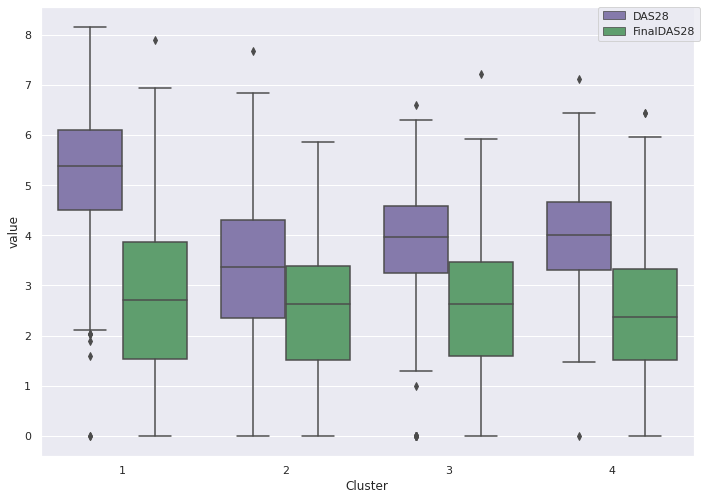

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot
a4_dims = (11.7, 8.27)
sns.set() 
fig, ax = plt.subplots(figsize=a4_dims)

# df_response['DAS_delta']= abs(df_response['DAS28'] - df_response['FinalDAS28'])
df = pd.melt(df_response[['DAS28', 'FinalDAS28', 'patnr']], id_vars=['patnr'], value_vars=['DAS28', 'FinalDAS28'])
df = df.merge(df_response[['Cluster', 'patnr', 'Treatment_shift']],left_on='patnr', right_on='patnr')
df['Cluster'] = df['Cluster'] + 1
sns.boxplot(x='Cluster', y='value', #z = 'FinalDAS28',
             palette=["m", "g"], hue='variable',
            data=df) # hue='Treatment_shift',
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

### #5.5 Get date of first treatment switch

In [6]:
def getFollowUp(row):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        return row['firstDateSwitch']
    else :
        return row['totalFollowUp']

    
def setStatus(row):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        return True
    else :
        return False

df_response['time'] = df_response.apply(lambda x: getFollowUp(x), axis=1)
df_response['event'] = df_response.apply(lambda x: setStatus(x), axis=1)

#df_response['firstDateSwith']

#### #5.5.1 assess first date switch

In [ ]:
def firstDateSwitch(df, df_treat, df_das):
    """ 
    Get the first date where treatment is switched and save this date in a dictionary
    
    This function will assess the first date  
    """
    d_firstSwitch = {}
    d_totalFollowUp = {}
    df_switchTable = pd.DataFrame(columns=["patnr", "Treatment",  "FinalTreatment", "MTX-starter","Cluster", "Event", "Days", "FollowUp"])
    
    for pat in df['patnr'].unique():
        # Either take days or new_days..
        df_pat = df_treat[((df_treat['patnr']==pat))]
            
        
        sub_df = df[df['patnr']==pat].copy()
        # Medication
        df_subdas =df_das[((df_das['patnr']==pat))].copy()
        
        d_med = df_pat.groupby('StartDateTreatment')['Drug'].apply(list).to_dict()
        
        # calculate follow up according to DAS table
        d_totalFollowUp[pat] = (pd.to_datetime(df_subdas['date'].max(), format='%Y-%m-%d', errors='ignore') - pd.to_datetime(df_subdas['date'].min(), format='%Y-%m-%d', errors='ignore')).days
        
        
        # first date
        try: 
            first_row = df_pat.iloc[0]
        except: 
            print('pat %s doesnt have treatment information' % (pat))
            d_firstSwitch[pat] = np.nan
            #df_switchTable.loc[len(df_switchTable)] = [pat, med, last_med, mtx_starter, sub_df['PhenoGraph_clusters'].iloc[0], event, delta]
            continue
        
        tol2 = 30
        
        # first date after pec
        l_first_date = [i for i in d_med.keys() if (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') < pd.to_datetime(first_row['StartDateTreatment'], format='%Y-%m-%d', errors='ignore') + pd.DateOffset(days=tol2)) and (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') >= pd.to_datetime(first_row['StartDateTreatment'], format='%Y-%m-%d', errors='ignore') - pd.DateOffset(days=tol2))]
        
        # Get last date
        last_row = df_pat.iloc[-1]
        
        med = [medi for i in l_first_date for medi in d_med[i]]#[-1]
        med = list(np.unique(med)) 
        delta = np.nan
        
        for index, rec in df_pat.iterrows(): # 
            last_med = []
            tol = 62
            event = False
            end_date_med = rec['StartDateTreatment'] 
            
            # Get all dates within ~1 year (15 months)
            l_last_date = [i for i in d_med.keys() if (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') < pd.to_datetime(end_date_med, format='%Y-%m-%d', errors='ignore') + pd.DateOffset(days=tol)) and (pd.to_datetime(i, format='%Y-%m-%d', errors='ignore') > pd.to_datetime(end_date_med, format='%Y-%m-%d', errors='ignore') - pd.DateOffset(days=tol))]
            pot_last_med = [medi for i in l_last_date for medi in d_med[i]]
            if list(np.unique(pot_last_med)) != []:
                last_med = list(np.unique(pot_last_med))
            
            # Count every treatment switch but ignore prednison/methotrexate
            if [i for i in last_med if i not in ['PREDNISOLON', 'METHYLPREDNISOLON']]!=[i for i in med if i not in ['PREDNISOLON', 'METHYLPREDNISOLON']] and rec['StartDateTreatment'] >= df_subdas['PEC'].iloc[0] :#  and rec['daysTreatment'] != 0  #  and last_med != []  and last_med != []
                delta =pd.to_datetime(rec['StartDateTreatment'], format='%Y-%m-%d', errors='ignore').tz_localize('UTC') - pd.to_datetime(df_subdas['PEC'].iloc[0], format='%Y-%m-%d', errors='ignore')
                delta = delta.days
                d_firstSwitch[pat] = delta
                event = True
                break
                
        # Check if patients start with Methotrexate
        mtx_starter = 'METHOTREXAAT' in med
        df_switchTable.loc[len(df_switchTable)] = [pat, med, last_med, mtx_starter, sub_df['PhenoGraph_clusters'].iloc[0], event, delta, d_totalFollowUp[pat]] 
        if pat not in d_firstSwitch.keys():
            d_firstSwitch[pat] = np.nan
    return d_firstSwitch, d_totalFollowUp, df_switchTable
d_firstSwitch, d_totalFollowUp, df_switchTable = firstDateSwitch(df_cluster, df_treat, df_das)

# add first date switch to response table
df_response['firstDateSwitch'] = df_response['patnr'].apply(lambda x : d_firstSwitch[x])

# add total followup to response table
df_response['totalFollowUp'] = df_response['patnr'].apply(lambda x : d_totalFollowUp[x])

df_switchTable.head()

## #5.6 Create Heatmap

We read the switch table and juxtapose the first treatment against the last treatment for each cluster. We effectively create 4 different heatmaps.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

MTX_STARTER = True
FOLLOWUP = 365 

def lookInPast(rec, FOLLOWUP):
    if rec['Days'] > FOLLOWUP :
        return rec['Treatment']
    else :
        return rec['FinalTreatment']

# Juxtapose the first treatment against the last treatment
for cluster in df_switchTable['Cluster'].unique():
    sub_df =df_switchTable[((df_switchTable['Cluster']==cluster) )].copy()
    
    if FOLLOWUP!=-1:
        sub_df['FinalTreatment'] = sub_df.apply(lambda x: lookInPast(x, FOLLOWUP), axis=1)
    if MTX_STARTER:
        sub_df = sub_df[sub_df['MTX-starter']==True]
    print('Patients that stay with baseline drug: ', len(sub_df[((sub_df['Event']==False) | (sub_df['Days']>FOLLOWUP))]))
    d_treat = {}
    l_unique_med = []
    l_ignore = ['METHYLPREDNISOLON', 'PREDNISOLON']
    for ix, row in sub_df.iterrows():
        for med in row['Treatment']: 
            # only save starting med in l_unique_med if there is a final med found!
            keep_med = False 
            for med2 in row['FinalTreatment']: 
                if '%s-%s' % (med, med2) in d_treat.keys() and med not in l_ignore and med2 not in l_ignore:
                    d_treat['%s-%s' % (med, med2)]+=1
                elif med not in l_ignore and med2 not in l_ignore:
                    d_treat['%s-%s' % (med, med2)]=1
                if med2 not in l_unique_med and med2 not in l_ignore:
                    keep_med = True
                    if med not in l_ignore:
                        l_unique_med.append(med2)
            if med not in l_unique_med and med not in l_ignore and keep_med==True:
                l_unique_med.append(med)
    df_heat = pd.DataFrame(index=l_unique_med, columns=l_unique_med)
    
    total = 0
    
    # Register the occurrence of each combination
    for key, value in d_treat.items():
        med1 = key.split('-')[0]
        med2 = key.split('-')[1]
        df_heat.at[med1,med2]= value
        total += value
    
    df_heat = df_heat.dropna(how='all')
    df_heat = df_heat.fillna(0)
    
    # Perform simple normalization
    df_heat = df_heat / sum(df_heat.sum())
    df_heat = df_heat*100

    # plot
    a4_dims = (14.7, 11.27)
    sns.set()
    fig, ax = plt.subplots(figsize=a4_dims)
    #if int(cluster)==2:
    if MTX_STARTER == True or int(cluster) in [2,3]: 
        fig, ax = plt.subplots(figsize=(10,13))
    
    # don't show zeroes
    mask = df_heat == 0
    
    ax = sns.heatmap(df_heat, annot=True, mask=mask, fmt = '.1f', square=1, linewidth=1., vmin=0, vmax=100, cmap="YlGnBu")
    for t in ax.texts: t.set_text(t.get_text() + "")
    plt.ylabel('Treatment at baseline')
    plt.xlabel('Final treatment (0-15 months after baseline)')
    
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    if MTX_STARTER == True : 
        plt.savefig('/exports/reum/tdmaarseveen/RA_Clustering/figures/5_treatment/MTX_treatmentShift_cluster%s.png' % (str(cluster)))
    else : 
        plt.savefig('/exports/reum/tdmaarseveen/RA_Clustering/figures/5_treatment/treatmentShift_cluster%s.png' % (str(cluster)))
    plt.clf()
    print('plot created')


## 5.7 Visualize Medication Trajectory of a specific patient [Experimental]

<ipython-input-35-64fda6c05183>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pat['StartDateTreatment'] = pd.to_datetime(df_pat['StartDateTreatment'])
<ipython-input-35-64fda6c05183>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pat['EndDateTreatment'] = pd.to_datetime(df_pat['EndDateTreatment'])


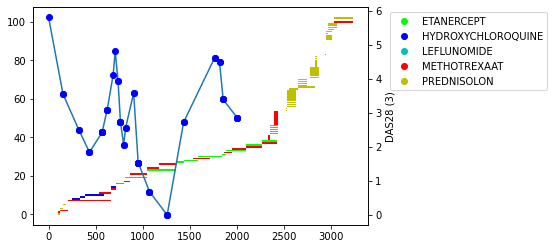

In [35]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np

def visualize_trajectory_pat(df_pat):
    """
    Input:
        df_pat = dataframe with all entries of a specific patient
    
    Description:
        Visualize the medication trajectory and DAS-score over time for a specific patient
    """
    d_color ={'TOCILIZUMAB' : 'm', 'METHOTREXAAT': 'r', 'HYDROXYCHLOROQUINE': 'b',
       'AZATHIOPRINE': 'orange', 'INFLIXIMAB': 'silver', 'ABATACEPT': 'tan', 'PREDNISOLON': 'y',
       'SULFASALAZINE': 'g', 'ETANERCEPT': 'lime', 'LEFLUNOMIDE': 'c', 'CERTOLIZUMAB PEGOL': 'purple',
       'CICLOSPORINE': 'darkviolet', 'ADALIMUMAB': 'olive', 'BARICITINIB': 'peachpuff', 'METHYLPREDNISOLON': 'teal',
       'GOLIMUMAB': 'hotpink', 'AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)': 'palegreen',
       'CYCLOFOSFAMIDE': 'coral', 'RITUXIMAB': 'darkred', 'TOFACITINIB': 'chocolate', 'No medication':'gray'}
    
    sub_df = df_pat.copy()
    sub_df = sub_df.dropna(subset=['treatID'])
    
    first_date = pd.to_datetime(pd.Series([i for i in sub_df['StartDateTreatment'] if type(i) != float]).min(), format='%Y-%m-%d', errors='ignore') - pd.DateOffset(days=sub_df['daysTreatment'].min())
    
    df_pat['StartDateTreatment'] = pd.to_datetime(df_pat['StartDateTreatment'])
    df_pat['EndDateTreatment'] = pd.to_datetime(df_pat['EndDateTreatment'])
    
    df_pat = df_pat.sort_values(by=['StartDateTreatment'])
    df_pat['daysTreatment'] = df_pat['EndDateTreatment'] -df_pat['StartDateTreatment']
    df_pat['start'] = df_pat['StartDateTreatment'] - first_date
    df_pat['daysTreatment'] = df_pat['daysTreatment'].dt.days
    df_pat['start'] = df_pat['start'].dt.days
    
    sub_df = df_pat.copy()
    sub_df = sub_df.drop_duplicates(subset=['treatID'])
    sub_df = sub_df.dropna(subset=['treatID'])
    x_mean = np.array(sub_df['daysTreatment'].values)
    x_std  = np.array(sub_df['start'].values) 
    y      = range(len(sub_df)) 
    l_col  = [d_color[i] for i in sub_df['Drug']]
    
    # Generate Legend automatically (select relevant medication)
    d_sub = {}
    for val in np.unique(sub_df['Drug']):
        d_sub[val] = d_color[val]
    
    
    df_pat = df_pat.sort_values(by='daysDAS')
    x2,y2 = df_pat['daysDAS'], df_pat['DAS28(3)']
    ax = plt.subplot(1, 1, 1)
    twin1 = ax.twinx()
    twin1.plot(x2,y2)
    twin1.plot(x2,y2, "ob")
    twin1.set_ylabel("DAS28 (3)")
        
    #pl.figure()
    ax.barh(y, width=x_mean, left=x_std, color=l_col)
    markers = [pl.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in d_sub.values()]
    ax.legend(markers, d_sub.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left',)
    return

visualize_trajectory_pat(df_treat[df_treat['patnr']==1]) 

## [UNUSED] Generate random sample of patients for each cluster (for validation)

In [ ]:
import random
df_sample = pd.DataFrame(columns=['patnr', 'cluster'])

for i in range(4):
    print(i)
    l_samples = random.sample(list(df_cluster[df_cluster['PhenoGraph_clusters']==i]['patnr']), k=10)
    for pat in l_samples:
        df_sample.loc[len(df_sample)] = [pat, i+1]

df_sample.sample(frac=1)
df_sample.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/data/5_validation/Sample_4clusters_Labelled.csv', index=False)

## [UNUSED] Plot LOESS

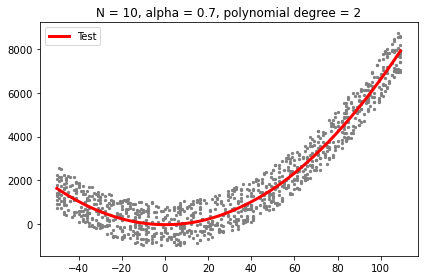

In [114]:
import statsmodels.api as sm 
import sys
sys.path.append(r'../src/4_downstream')
import medicationResponse_functions as medFunc
import importlib as imp

#imp.reload(medFunc)

np.random.seed(10)
x_values = np.random.randint(-50,110,size=(1000))
y_values = np.square(x_values)/1.5 + np.random.randint(-1000,1000, size=len(x_values))
df = pd.DataFrame({"Xvalue" : x_values,
                    "Yvalue" : y_values
                    })


#evalDF = medFunc.loess("days", "DAS28(3)", data = df_das, alpha=0.7, poly_degree=2)

evalDF = medFunc.loess("Xvalue", "Yvalue", data = df, alpha=0.7, poly_degree=2)

fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(df_das["days"], df_das["DAS28(3)"], color="grey", marker="o", s=5, label="_nolegend_")
ax1.scatter(df["Xvalue"], df["Yvalue"], color="grey", marker="o", s=5, label="_nolegend_")
ax1.plot(evalDF['v'], evalDF['g'], color='red', linewidth= 3, label="Test")


plt.title('N = 10, alpha = 0.7, polynomial degree = 2')
plt.legend()
plt.tight_layout()
plt.show()